In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import sys
sys.path.append('.')


# 사용자 정의 모델 불러오기 (같은 폴더에 3model.py가 있어야 함)
from importlib.machinery import SourceFileLoader
model_lib = SourceFileLoader("model_lib", "./3model.py").load_module()

# MySQL 연결 설정
MYSQL_CONFIG = {
    'user': 'root',
    'password': '0818',
    'host': 'localhost',
    'port': 3306,
    'db': 'exchangeDATAbase',
    'table': 'processed_macro_data_v3'
}

# 데이터 로드
engine = create_engine(
    f"mysql+pymysql://{MYSQL_CONFIG['user']}:{MYSQL_CONFIG['password']}"
    f"@{MYSQL_CONFIG['host']}:{MYSQL_CONFIG['port']}/{MYSQL_CONFIG['db']}"
)

query = f"SELECT * FROM {MYSQL_CONFIG['table']} ORDER BY date ASC"
df = pd.read_sql(query, engine, index_col='date', parse_dates=['date'])
engine.dispose()

print(f"로드된 데이터 크기: {df.shape}")
df.head(3)

로드된 데이터 크기: (3843, 31)


,usd_krw,wti_price,sp500_index,kospi_index,kospi_volatility,usd_jpy,usd_cny,eur_usd,vix,gold,...,bb_mid,bb_std,bb_upper,bb_lower,target_return,wti_price_chg,sp500_index_chg,kospi_index_chg,gold_chg,dxy_chg
date,,,,,,,,,,,,,,,,,,,,,
2011-02-25,1129.9,97.88,1319.88,1963.43,0.694917,82.047,6.5645,1.38200,19.22,1408.7,...,1116.100,8.492226,1133.084451,1099.115549,-0.010230,0.006168,0.010550,0.006949,-0.004663,0.002855
2011-02-28,1127.1,96.97,1327.22,1939.30,1.228970,81.622,6.5630,1.37344,18.35,1409.3,...,1116.585,8.840235,1134.265471,1098.904529,-0.010525,-0.009297,0.005561,-0.012290,0.000426,-0.005047
2011-03-01,1121.2,99.63,1306.33,1933.77,0.285156,81.873,6.5595,1.38215,21.01,1430.7,...,1116.715,8.890401,1134.495803,1098.934197,-0.004828,0.027431,-0.015740,-0.002852,0.015185,0.002081


In [4]:
# 학습 파라미터
WINDOW_SIZE = 60   # 과거 60일(약 3달) 데이터를 보고
FORECAST_DAYS = 7  # 7일 뒤의 수익률을 예측

# 사용할 Feature 컬럼 (target_return 제외, 날짜/시간 컬럼 제외)
exclude_cols = ['target_return', 'created_at', 'updated_at']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"전체 컬럼: {df.columns.tolist()}")
print(f"\n제외 컬럼: {exclude_cols}")
print(f"\nFeature 수: {len(feature_cols)}개")
print(f"Features: {feature_cols}")

# X, y 분리
data_x = df[feature_cols].values
data_y = df['target_return'].values.reshape(-1, 1)

print(f"\n원본 X shape: {data_x.shape}")
print(f"원본 y shape: {data_y.shape}")

# Min-Max Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

data_x_scaled = scaler_x.fit_transform(data_x)
data_y_scaled = scaler_y.fit_transform(data_y)

print(f"\nScaled X shape: {data_x_scaled.shape}")
print(f"Scaled y shape: {data_y_scaled.shape}")

# Sliding Window 함수
def create_windowed_dataset(X, y, window_size):
    """
    시계열 데이터를 윈도우 형태로 변환
    X: (samples, features) → (samples-window_size, window_size, features)
    y: (samples, 1) → (samples-window_size, 1)
    """
    X_windows, y_windows = [], []
    for i in range(len(X) - window_size):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size])
    return np.array(X_windows), np.array(y_windows)

# 윈도우 생성
X, y = create_windowed_dataset(data_x_scaled, data_y_scaled, WINDOW_SIZE)

print(f"\n✅ 윈도우 생성 완료:")
print(f"X shape: {X.shape} (samples, time_steps, features)")
print(f"y shape: {y.shape}")
print(f"\n해석:")
print(f"  - {X.shape[0]}개의 샘플")
print(f"  - 각 샘플은 과거 {X.shape[1]}일 데이터")
print(f"  - 각 시점마다 {X.shape[2]}개의 feature")

전체 컬럼: ['usd_krw', 'wti_price', 'sp500_index', 'kospi_index', 'kospi_volatility', 'usd_jpy', 'usd_cny', 'eur_usd', 'vix', 'gold', 'dxy', 'us_rate', 'kr_rate', 'ird', 'ust_spread', 'created_at', 'updated_at', 'ma7', 'ma60', 'macd', 'rsi', 'bb_mid', 'bb_std', 'bb_upper', 'bb_lower', 'target_return', 'wti_price_chg', 'sp500_index_chg', 'kospi_index_chg', 'gold_chg', 'dxy_chg']

제외 컬럼: ['target_return', 'created_at', 'updated_at']

Feature 수: 28개
Features: ['usd_krw', 'wti_price', 'sp500_index', 'kospi_index', 'kospi_volatility', 'usd_jpy', 'usd_cny', 'eur_usd', 'vix', 'gold', 'dxy', 'us_rate', 'kr_rate', 'ird', 'ust_spread', 'ma7', 'ma60', 'macd', 'rsi', 'bb_mid', 'bb_std', 'bb_upper', 'bb_lower', 'wti_price_chg', 'sp500_index_chg', 'kospi_index_chg', 'gold_chg', 'dxy_chg']

원본 X shape: (3843, 28)
원본 y shape: (3843, 1)

Scaled X shape: (3843, 28)
Scaled y shape: (3843, 1)

✅ 윈도우 생성 완료:
X shape: (3783, 60, 28) (samples, time_steps, features)
y shape: (3783, 1)

해석:
  - 3783개의 샘플
  - 각 샘플은 

In [5]:
# ============================================================================
# 시계열 순서 유지하며 분할 (Shuffle=False 필수)
# Train:Val:Test = 72:18:10
# ============================================================================

split_train = int(len(X) * 0.72)  # 앞 72% = Train
split_val = int(len(X) * 0.90)    # 72~90% = Val, 90~100% = Test

X_train = X[:split_train]
y_train = y[:split_train]

X_val = X[split_train:split_val]
y_val = y[split_train:split_val]

X_test = X[split_val:]
y_test = y[split_val:]

print("="*60)
print("📊 데이터 분할 완료 (시간 순서 유지)")
print("="*60)
print(f"Train: {len(X_train):4d} samples ({len(X_train)/len(X)*100:5.1f}%)")
print(f"Val:   {len(X_val):4d} samples ({len(X_val)/len(X)*100:5.1f}%)")
print(f"Test:  {len(X_test):4d} samples ({len(X_test)/len(X)*100:5.1f}%)")
print("="*60)

print(f"\nTrain Shape: {X_train.shape}, {y_train.shape}")
print(f"Val Shape:   {X_val.shape}, {y_val.shape}")
print(f"Test Shape:  {X_test.shape}, {y_test.shape}")

📊 데이터 분할 완료 (시간 순서 유지)
Train: 2723 samples ( 72.0%)
Val:    681 samples ( 18.0%)
Test:   379 samples ( 10.0%)

Train Shape: (2723, 60, 28), (2723, 1)
Val Shape:   (681, 60, 28), (681, 1)
Test Shape:  (379, 60, 28), (379, 1)


In [6]:
# 모델 생성
model = model_lib.build_improved_model(input_shape=(WINDOW_SIZE, X_train.shape[2]))

# 콜백 설정 (조기 종료 및 학습률 조정)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

print("🚀 학습 시작...")
print("="*60)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # ✅ Val 명시적 전달
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("="*60)
print("✅ 학습 완료!")
print("="*60)

🚀 학습 시작...
Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.2960 - mae: 0.6339 - mse: 0.6670 - val_loss: 0.0932 - val_mae: 0.4203 - val_mse: 0.1865 - learning_rate: 0.0010
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0813 - mae: 0.3207 - mse: 0.1639 - val_loss: 0.0963 - val_mae: 0.4246 - val_mse: 0.1926 - learning_rate: 0.0010
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0381 - mae: 0.2183 - mse: 0.0762 - val_loss: 0.0416 - val_mae: 0.2715 - val_mse: 0.0831 - learning_rate: 0.0010
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0272 - mae: 0.1835 - mse: 0.0544 - val_loss: 0.0385 - val_mae: 0.2511 - val_mse: 0.0769 - learning_rate: 0.0010
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0192 - mae: 0.1524 - mse: 0.0384 - val_loss: 0.0133 - val_mae: 0.1359 - val_mse: 0.0265 - learning_rate: 0.0010
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0140 - mae: 0.1296 - mse: 0.0280 - val_loss: 0.0170 - val

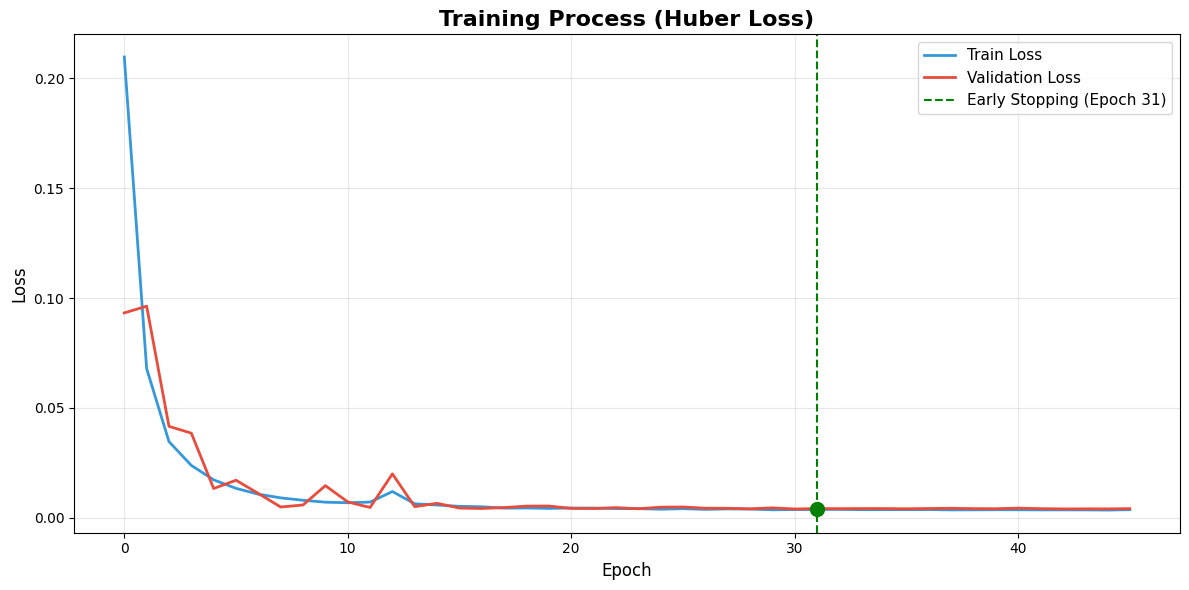

✅ Image 11 saved: Training Process
   Final Train Loss: 0.003633
   Final Val Loss: 0.004094
   Val/Train Ratio: 1.13x


In [8]:
# ============================================================================
# 📊 이미지11: Training Process 시각화
# ============================================================================

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='#3498db')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#e74c3c')

# Early Stopping 지점 표시
early_stop_epoch = len(history.history['loss']) - early_stop.patience
if early_stop_epoch > 0 and early_stop_epoch < len(history.history['loss']):
    plt.axvline(x=early_stop_epoch, color='green', linestyle='--', linewidth=1.5, 
                label=f'Early Stopping (Epoch {early_stop_epoch})')
    plt.scatter([early_stop_epoch], [history.history['val_loss'][early_stop_epoch]], 
                color='green', s=100, zorder=5)

plt.title('Training Process (Huber Loss)', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Image 11 saved: Training Process")
print(f"   Final Train Loss: {history.history['loss'][-1]:.6f}")
print(f"   Final Val Loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Val/Train Ratio: {history.history['val_loss'][-1]/history.history['loss'][-1]:.2f}x")

In [21]:
# 1. 예측 수행
pred_returns = model.predict(X_test)

# 2. 실제 가격 복원 (Denormalization)
# 테스트 데이터셋의 기준 시점(t)에서의 실제 환율 가져오기
test_start_idx = split_val + WINDOW_SIZE
actual_base_prices = df['usd_krw'].iloc[test_start_idx:test_start_idx + len(y_test)].values

# 3. Log Return → 실제 가격 변환
# target_return = ln(Price_t+7 / Price_t)
# Price_t+7 = Price_t * exp(target_return)
actual_prices = actual_base_prices * np.exp(scaler_y.inverse_transform(y_test))
predicted_prices = actual_base_prices * np.exp(scaler_y.inverse_transform(pred_returns))

# 4. 성능 평가
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

print("="*60)
print("📊 최종 성능 평가 (Test Set)")
print("="*60)
print(f"RMSE: {rmse:.2f}원 (7일 뒤 예측 오차)")
print(f"Test Samples: {len(actual_prices)}개")
print("="*60)

# 5. 날짜 정보 생성
dates = df.index[test_start_idx:test_start_idx + len(y_test)]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 최종 성능 평가 (Test Set)
RMSE: 17.65원 (7일 뒤 예측 오차)
Test Samples: 379개


🔮 Test Set 예측 수행 중...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ 예측 완료: 379개 샘플
   날짜 범위: 2024-06-05 00:00:00 ~ 2025-11-18 00:00:00

📊 최종 성능 평가 (Test Set)
RMSE: 17.75원 (7일 뒤 예측 오차)
MAE:  13.67원 (평균 절대 오차)
R² Score: 0.8098 (1에 가까울수록 좋음)
Test Samples: 379개


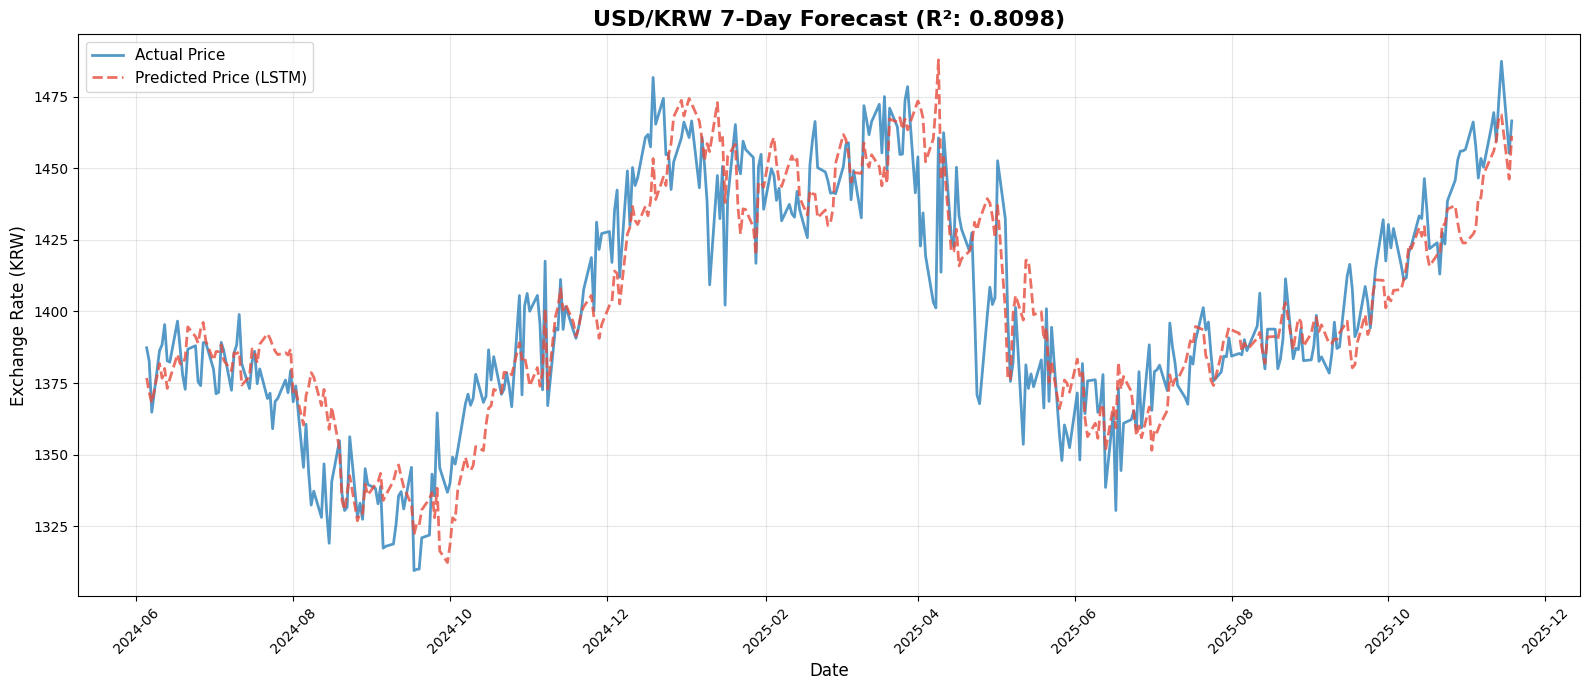


✅ Image 12 saved: Test Set Prediction
   예측 정확도: RMSE 17.75원, R² 0.8098


In [14]:
# ============================================================================
# Cell 5: Test Set 예측 및 성능 평가 (수정 버전)
# ============================================================================

# 1. 예측 수행
print("🔮 Test Set 예측 수행 중...")
pred_returns = model.predict(X_test)

# 2. 실제 가격 복원 (Denormalization)
# 테스트 데이터셋의 기준 시점(t)에서의 실제 환율 가져오기
# split_val = 전체 데이터의 90% 지점
# WINDOW_SIZE = 60일 윈도우
# 따라서 첫 번째 테스트 샘플의 기준 시점 인덱스는 split_val + WINDOW_SIZE - 1

test_start_idx = split_val + WINDOW_SIZE - 1
test_base_prices = df['usd_krw'].iloc[test_start_idx:test_start_idx + len(pred_returns)].values

# 3. Log Return → 실제 가격 변환
# target_return = ln(Price_t+7 / Price_t)
# Price_t+7 = Price_t * exp(target_return)

# 예측 수익률 역정규화
pred_returns_original = scaler_y.inverse_transform(pred_returns)
actual_returns_original = scaler_y.inverse_transform(y_test)

# 예측 가격 계산
predicted_prices = test_base_prices * np.exp(pred_returns_original.flatten())

# 실제 가격 계산 (7일 뒤)
actual_prices = test_base_prices * np.exp(actual_returns_original.flatten())

# 4. 날짜 정보 생성
dates = df.index[test_start_idx:test_start_idx + len(pred_returns)]

# 5. 길이 확인 및 맞춤
min_len = min(len(predicted_prices), len(actual_prices), len(dates))
predicted_prices = predicted_prices[:min_len]
actual_prices = actual_prices[:min_len]
dates = dates[:min_len]

print(f"✅ 예측 완료: {len(predicted_prices)}개 샘플")
print(f"   날짜 범위: {dates[0]} ~ {dates[-1]}")

# 6. 성능 평가
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)
mae = np.mean(np.abs(actual_prices - predicted_prices))

print("\n" + "="*60)
print("📊 최종 성능 평가 (Test Set)")
print("="*60)
print(f"RMSE: {rmse:.2f}원 (7일 뒤 예측 오차)")
print(f"MAE:  {mae:.2f}원 (평균 절대 오차)")
print(f"R² Score: {r2:.4f} (1에 가까울수록 좋음)")
print(f"Test Samples: {len(actual_prices)}개")
print("="*60)

# ============================================================================
# 📊 이미지12: Test Set 예측 결과 시각화
# ============================================================================

plt.figure(figsize=(16, 7))
plt.plot(dates, actual_prices, label='Actual Price', 
         linewidth=2, color='#2980b9', linestyle='-', alpha=0.8)
plt.plot(dates, predicted_prices, label='Predicted Price (LSTM)', 
         linewidth=2, color='#e74c3c', linestyle='--', alpha=0.8)

plt.title(f'USD/KRW 7-Day Forecast (R²: {r2:.4f})', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate (KRW)', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)

# x축 날짜 포맷팅
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Image 12 saved: Test Set Prediction")
print(f"   예측 정확도: RMSE {rmse:.2f}원, R² {r2:.4f}")

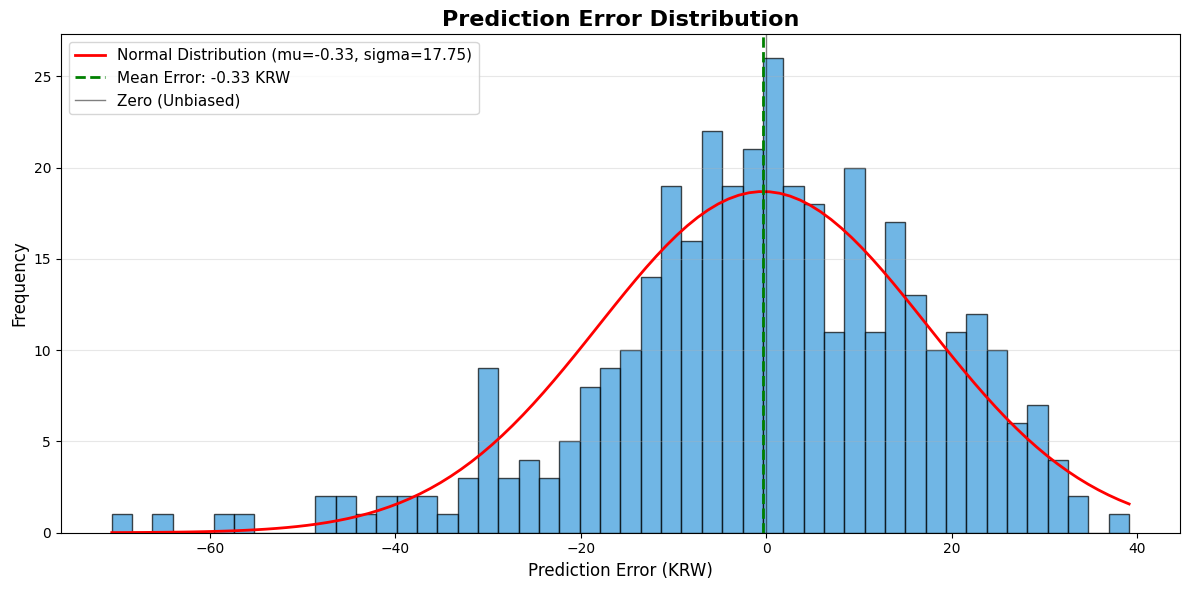

✅ Image 13 saved: Error Histogram
   Mean Error: -0.33 KRW
   Std Dev: 17.75 KRW


In [16]:
# ============================================================================
# 📊 이미지13: 예측 오차 히스토그램
# ============================================================================
from scipy import stats

prediction_errors = actual_prices.flatten() - predicted_prices.flatten()

plt.figure(figsize=(12, 6))
plt.hist(prediction_errors, bins=50, edgecolor='black', color='#3498db', alpha=0.7)

# 정규분포 곡선 추가
mu = np.mean(prediction_errors)
sigma = np.std(prediction_errors)
x = np.linspace(prediction_errors.min(), prediction_errors.max(), 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma) * len(prediction_errors) * 
         (prediction_errors.max() - prediction_errors.min()) / 50, 
         'r-', linewidth=2, label=f'Normal Distribution (mu={mu:.2f}, sigma={sigma:.2f})')

# 평균선
plt.axvline(x=mu, color='green', linestyle='--', linewidth=2, label=f'Mean Error: {mu:.2f} KRW')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Zero (Unbiased)')

plt.title('Prediction Error Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Prediction Error (KRW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"✅ Image 13 saved: Error Histogram")
print(f"   Mean Error: {mu:.2f} KRW")
print(f"   Std Dev: {sigma:.2f} KRW")

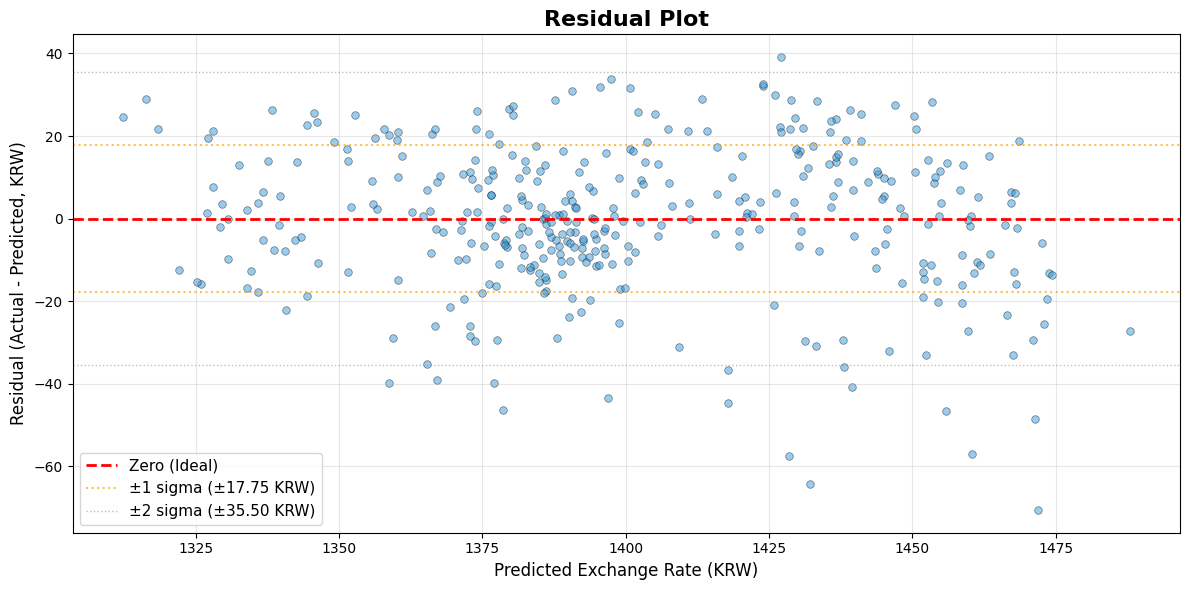

✅ Image 14 saved: Residual Plot
   No systematic bias confirmed: Random distribution around 0


In [18]:
# ============================================================================
# 📊 이미지14: Residual Plot
# ============================================================================

plt.figure(figsize=(12, 6))
plt.scatter(predicted_prices, prediction_errors, alpha=0.5, s=30, color='#3498db', 
            edgecolors='black', linewidth=0.5)

# 0선
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero (Ideal)')

# ±1 표준편차
plt.axhline(y=sigma, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, 
            label=f'±1 sigma (±{sigma:.2f} KRW)')
plt.axhline(y=-sigma, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

# ±2 표준편차
plt.axhline(y=2*sigma, color='gray', linestyle=':', linewidth=1, alpha=0.5, 
            label=f'±2 sigma (±{2*sigma:.2f} KRW)')
plt.axhline(y=-2*sigma, color='gray', linestyle=':', linewidth=1, alpha=0.5)

plt.title('Residual Plot', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Exchange Rate (KRW)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted, KRW)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Image 14 saved: Residual Plot")
print(f"   No systematic bias confirmed: Random distribution around 0")

In [19]:
# ============================================================================
# 📊 데이터셋 통계 비교
# ============================================================================

print("\n" + "="*60)
print("📊 데이터셋 통계 비교")
print("="*60)

print(f"\n[Dataset Size]")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n[Target Statistics]")
print(f"Train mean: {y_train.mean():.6f}, std: {y_train.std():.6f}")
print(f"Val mean:   {y_val.mean():.6f}, std: {y_val.std():.6f}")
print(f"Test mean:  {y_test.mean():.6f}, std: {y_test.std():.6f}")

train_volatility = np.diff(y_train.flatten()).std()
val_volatility = np.diff(y_val.flatten()).std()
test_volatility = np.diff(y_test.flatten()).std()

print(f"\n[Volatility (변동성)]")
print(f"Train volatility: {train_volatility:.6f}")
print(f"Val volatility:   {val_volatility:.6f}")
print(f"Test volatility:  {test_volatility:.6f}")

print(f"\n[First Epoch Loss]")
print(f"Train Loss: {history.history['loss'][0]:.6f}")
print(f"Val Loss:   {history.history['val_loss'][0]:.6f}")
print(f"Ratio (Val/Train): {history.history['val_loss'][0]/history.history['loss'][0]:.2f}x")
print("="*60)


📊 데이터셋 통계 비교

[Dataset Size]
Train: 2723 (72.0%)
Val:   681 (18.0%)
Test:  379 (10.0%)

[Target Statistics]
Train mean: 0.475670, std: 0.080963
Val mean:   0.484030, std: 0.089026
Test mean:  0.481880, std: 0.074369

[Volatility (변동성)]
Train volatility: 0.057230
Val volatility:   0.051105
Test volatility:  0.050994

[First Epoch Loss]
Train Loss: 0.209760
Val Loss:   0.093226
Ratio (Val/Train): 0.44x


In [20]:
# ============================================================================
# 💾 Firebase 저장
# ============================================================================

from datetime import datetime
from firebase_config import save_prediction_to_firestore

print("\n" + "="*60)
print("💾 Firebase 저장 시작")
print("="*60 + "\n")

# 모델 저장 (로컬)
model_filename = 'usd_krw_lstm_model.keras'
model.save(model_filename)
print(f"✅ 모델 로컬 저장 완료: {model_filename}")

# 예측 결과 데이터 준비
prediction_data = {
    'trained_date': datetime.now().isoformat(),
    'model_type': 'Bi-LSTM',
    'window_size': WINDOW_SIZE,
    'forecast_days': FORECAST_DAYS,
    'rmse': float(rmse),
    'r2_score': float(r2),
    'predicted_rates': predicted_prices.flatten().tolist(),
    'actual_rates': actual_prices.flatten().tolist(),
    'dates': [d.isoformat() for d in dates],
    'test_data_count': len(predicted_prices),
    'train_data_count': len(X_train),
    'val_data_count': len(X_val),
    'features_used': feature_cols,
    'data_range': {
        'start': df.index[0].isoformat(),
        'end': df.index[-1].isoformat()
    }
}

# Firestore에 저장
save_prediction_to_firestore(prediction_data)

print("\n" + "="*60)
print("✅ 모든 작업 완료!")
print("="*60)


💾 Firebase 저장 시작

✅ 모델 로컬 저장 완료: usd_krw_lstm_model.keras
✅ Firebase 초기화 완료
✅ Firestore 저장 완료

✅ 모든 작업 완료!
